In [1]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import datetime

In [3]:
withGold = False
withOil = False
lossFunction = 'CrossEntrophyLoss'
# lossFunction = 'FocalLoss'
withMacdSignal = True

In [6]:
base_date = datetime.date(2008, 1, 30)
start_date = (base_date + datetime.timedelta(days=653)).strftime('%Y-%m-%d')
print("start_date =",start_date)
# start_date = "2011-01-30"
end_date = "2019-08-30"
yfdata = yf.download('^GSPC', start=start_date, end=end_date)
golddata = yf.download('GC=F', start=start_date, end=end_date)
oildata = yf.download('CL=F', start=start_date, end=end_date)
train_date_begin = pd.Timestamp('2013-01-30')
if train_date_begin in yfdata.index:
    train_date_index = yfdata.index.get_loc(train_date_begin)
    print(f"The index for {train_date_begin.date()} is {train_date_index}")
else:
    print(f"{train_date_begin.date()} is not in the index.")

start_date = 2009-11-13
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
The index for 2013-01-30 is 806


In [4]:
target_date = pd.Timestamp('2013-01-30')
if target_date in yfdata.index:
    index_for_date = yfdata.index.get_loc(target_date)
    print(f"The index for {target_date.date()} is {index_for_date}")
else:
    print(f"{target_date.date()} is not in the index.")

The index for 2013-01-30 is 502


In [13]:
from yf_dataset import get_macd_param
get_macd_param(yfdata)
yfdata

Open         High          Low        Close    Adj Close  \
Date                                                                          
2011-01-31  1276.500000  1287.170044  1276.500000  1286.119995  1286.119995   
2011-02-01  1289.140015  1308.859985  1289.140015  1307.589966  1307.589966   
2011-02-02  1305.910034  1307.609985  1302.619995  1304.030029  1304.030029   
2011-02-03  1302.770020  1308.599976  1294.829956  1307.099976  1307.099976   
2011-02-04  1307.010010  1311.000000  1301.670044  1310.869995  1310.869995   
...                 ...          ...          ...          ...          ...   
2019-08-23  2911.070068  2927.010010  2834.969971  2847.110107  2847.110107   
2019-08-26  2866.699951  2879.270020  2856.000000  2878.379883  2878.379883   
2019-08-27  2893.139893  2898.790039  2860.590088  2869.159912  2869.159912   
2019-08-28  2861.280029  2890.030029  2853.050049  2887.939941  2887.939941   
2019-08-29  2910.370117  2930.500000  2905.669922  2924.580078  2924.580078   

                Volume macd Param  
Date                               
2011-01-31  4167160000    5,24,11  
2011-02-01  5164500000    5,24,11  
2011-02-02  4098260000    5,24,11  
2011-02-03  4370990000    5,24,11  
2011-02-04  3925950000    5,24,11  
...                ...        ...  
2019-08-23  3942520000     5,20,9  
2019-08-26  2859790000     5,20,9  
2019-08-27  3537490000     5,20,9  
2019-08-28  3102480000     5,20,9  
2019-08-29  3177150000     5,20,9  

[2160 rows x 7 columns]

In [14]:
macdParamOptimize = True
def parse_macd_params(param_string):
    return map(int, param_string.split(','))

def getMacdSignal(yfdata, macdParamOptimize=False):
    if macdParamOptimize:
        for index, row in yfdata.iterrows():
            fast_span, slow_span, signal_span = parse_macd_params(row['macd Param'])

            current_data = yfdata.loc[:index]
            
            current_data['Fast EMA'] = current_data['Adj Close'].ewm(span=fast_span, adjust=False).mean()
            current_data['Slow EMA'] = current_data['Adj Close'].ewm(span=slow_span, adjust=False).mean()
            
            current_data['MACD'] = current_data['Fast EMA'] - current_data['Slow EMA']
            current_data['Signal Line'] = current_data['MACD'].ewm(span=signal_span, adjust=False).mean()

            last_macd = current_data['MACD'].iloc[-1]
            last_signal_line = current_data['Signal Line'].iloc[-1]
            prev_macd = current_data['MACD'].iloc[-2] if len(current_data) > 1 else last_macd
            prev_signal_line = current_data['Signal Line'].iloc[-2] if len(current_data) > 1 else last_signal_line

            if last_macd > last_signal_line and prev_macd <= prev_signal_line:
                yfdata.at[index, 'Signal'] = 0  # 买入信号
            elif last_macd < last_signal_line and prev_macd >= prev_signal_line:
                yfdata.at[index, 'Signal'] = 2  # 卖出信号
            else:
                yfdata.at[index, 'Signal'] = 1  # 保持信号
    else:
        fast_span = 5  # 快速EMA周期
        slow_span = 20  # 慢速EMA周期
        signal_span = 9  # 信号线周期
        yfdata['Fast EMA'] = yfdata['Adj Close'].ewm(span=fast_span, adjust=False).mean()
        yfdata['Slow EMA'] = yfdata['Adj Close'].ewm(span=slow_span, adjust=False).mean()

        # 计算MACD线
        yfdata['MACD'] = yfdata['Fast EMA'] - yfdata['Slow EMA']

        # 计算信号线
        yfdata['Signal Line'] = yfdata['MACD'].ewm(span=signal_span, adjust=False).mean()
        # 初始化信号列
        yfdata['Signal'] = 1

        # 找到买入信号和卖出信号
        for i in range(1, len(yfdata)):
            if yfdata['MACD'].iloc[i] > yfdata['Signal Line'].iloc[i] and yfdata['MACD'].iloc[i - 1] <= yfdata['Signal Line'].iloc[i - 1]:
                yfdata['Signal'].iloc[i] = 0  # 买入信号
            elif yfdata['MACD'].iloc[i] < yfdata['Signal Line'].iloc[i] and yfdata['MACD'].iloc[i - 1] >= yfdata['Signal Line'].iloc[i - 1]:
                yfdata['Signal'].iloc[i] = 2  # 卖出信号
    return

In [15]:
getMacdSignal(yfdata, macdParamOptimize=macdParamOptimize)

C:\Users\tony\AppData\Local\Temp\ipykernel_15832\228042769.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['Fast EMA'] = current_data['Adj Close'].ewm(span=fast_span, adjust=False).mean()
C:\Users\tony\AppData\Local\Temp\ipykernel_15832\228042769.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['Slow EMA'] = current_data['Adj Close'].ewm(span=slow_span, adjust=False).mean()
C:\Users\tony\AppData\Local\Temp\ipykernel_15832\228042769.py:15: SettingWithCopyWarning: 
A value i

In [16]:
yfdata_dates = yfdata.index
golddata_dates = golddata.index

# 找出 yfdata 有而 golddata 没有的日期
missing_dates = yfdata_dates[~yfdata_dates.isin(golddata_dates)]
missing_data = pd.DataFrame(index=missing_dates,columns=golddata.columns)
for date in missing_dates:
    previous_date = golddata_dates[golddata_dates < date]
    if not previous_date.empty:
        last_known_data = golddata.loc[previous_date.max()]
        missing_data.loc[date] = last_known_data

golddata = pd.concat([golddata, missing_data])
golddata = golddata.add_prefix('gold ')
golddata = golddata.sort_index()


In [17]:
golddata.isna().any().any()

False

In [18]:
yfdata_dates = yfdata.index
oildata_dates = oildata.index

# 找出 yfdata 有而 oildata 没有的日期
missing_dates = yfdata_dates[~yfdata_dates.isin(oildata_dates)]
missing_data = pd.DataFrame(index=missing_dates,columns=oildata.columns)
for date in missing_dates:
    previous_date = oildata_dates[oildata_dates < date]
    if not previous_date.empty:
        last_known_data = oildata.loc[previous_date.max()]
        missing_data.loc[date] = last_known_data

oildata = pd.concat([oildata, missing_data])
oildata = oildata.add_prefix('oil ')
oildata = oildata.sort_index()

oildata.isna().any().any()

False

In [20]:
days = 8 #多取一天後續方便計算label
date_cols = []
price_cols = yfdata.columns.tolist()
price_cols.remove('macd Param')
price_cols.append('gold Adj Close')
price_cols.append('oil Adj Close')
all_data = {}
sliding_window = 1

def group_by_week(data,price_col):
    local_df = []
    for i in range(len(data)):
        if np.isnan(data[price_col][i]): 
            print(str(data.index[i]))
            break
        local_df.append(data[price_col][i])
        
        if len(local_df) == days:
            col_name = str(data.index[i - days + 1]) + ' ~ ' + str(data.index[i])
            if price_col == price_cols[0]:
                date_cols.append(col_name)
            all_data[(price_col, col_name)] = local_df.copy()
            for _ in range(sliding_window):
                local_df.pop(0) 

for price_col in price_cols:
    if price_col.startswith('gold'):
        group_by_week(golddata, price_col)
    elif price_col.startswith('oil'):
        group_by_week(oildata, price_col)
    else: 
        group_by_week(yfdata, price_col)


multi_columns = pd.MultiIndex.from_product([price_cols,date_cols],names=['price','date'])
group_by_days_yfdata = pd.DataFrame(data=all_data,columns=multi_columns)
test = group_by_days_yfdata['gold Adj Close']

C:\Users\tony\AppData\Local\Temp\ipykernel_15832\2591190332.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(data[price_col][i]):
C:\Users\tony\AppData\Local\Temp\ipykernel_15832\2591190332.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  local_df.append(data[price_col][i])


In [21]:
data = group_by_days_yfdata
# data = data.fillna(0)
print("If there is NAN in data? ",data.isnull().values.any())
returns = data['Adj Close'].pct_change().fillna(0) 
print(returns.keys())
scaled_returns = StandardScaler().fit_transform(returns) #Z-score標準化:mean = 0,std = 1，後續用來計算相關性
# 計算各週之間的相關性
correlation_matrix = np.corrcoef(scaled_returns, rowvar=False)
correlation_matrix

If there is NAN in data?  False
Index(['2011-01-31 00:00:00 ~ 2011-02-09 00:00:00',
       '2011-02-01 00:00:00 ~ 2011-02-10 00:00:00',
       '2011-02-02 00:00:00 ~ 2011-02-11 00:00:00',
       '2011-02-03 00:00:00 ~ 2011-02-14 00:00:00',
       '2011-02-04 00:00:00 ~ 2011-02-15 00:00:00',
       '2011-02-07 00:00:00 ~ 2011-02-16 00:00:00',
       '2011-02-08 00:00:00 ~ 2011-02-17 00:00:00',
       '2011-02-09 00:00:00 ~ 2011-02-18 00:00:00',
       '2011-02-10 00:00:00 ~ 2011-02-22 00:00:00',
       '2011-02-11 00:00:00 ~ 2011-02-23 00:00:00',
       ...
       '2019-08-07 00:00:00 ~ 2019-08-16 00:00:00',
       '2019-08-08 00:00:00 ~ 2019-08-19 00:00:00',
       '2019-08-09 00:00:00 ~ 2019-08-20 00:00:00',
       '2019-08-12 00:00:00 ~ 2019-08-21 00:00:00',
       '2019-08-13 00:00:00 ~ 2019-08-22 00:00:00',
       '2019-08-14 00:00:00 ~ 2019-08-23 00:00:00',
       '2019-08-15 00:00:00 ~ 2019-08-26 00:00:00',
       '2019-08-16 00:00:00 ~ 2019-08-27 00:00:00',
       '2019-08-19 00

array([[ 1.        , -0.36727761, -0.27048959, ...,  0.28624785,
        -0.30040505,  0.09645067],
       [-0.36727761,  1.        ,  0.1310953 , ..., -0.59253527,
        -0.17798629, -0.23256388],
       [-0.27048959,  0.1310953 ,  1.        , ...,  0.50907856,
        -0.30571374, -0.13618199],
       ...,
       [ 0.28624785, -0.59253527,  0.50907856, ...,  1.        ,
        -0.49407569,  0.00516179],
       [-0.30040505, -0.17798629, -0.30571374, ..., -0.49407569,
         1.        , -0.29780148],
       [ 0.09645067, -0.23256388, -0.13618199, ...,  0.00516179,
        -0.29780148,  1.        ]])

In [23]:
from torch_geometric.data import Data

In [25]:
def min_max_scaling(data, feature_range=(0, 1)):
    """
    Min-Max Scaling for data.

    Parameters:
    - data: A NumPy array containing the data to be scaled.
    - feature_range: A tuple specifying the desired feature range (default is [0, 1]).

    Returns:
    - scaled_data: The scaled data within the specified feature range.
    """
    min_val, max_val = feature_range
    min_data = np.min(data, axis=0)
    max_data = np.max(data, axis=0)
    scaled_data = (data - min_data) / (max_data - min_data) * (max_val - min_val) + min_val
    return scaled_data

In [26]:
# 將相關性矩陣轉換為鄰接矩陣
adjacency_matrix = torch.tensor(correlation_matrix)

src_nodes, dst_nodes = np.where((adjacency_matrix > 0.7))
directed_index = np.where((src_nodes < dst_nodes) & ((dst_nodes - src_nodes) <= 495))
src_nodes = src_nodes[directed_index]
dst_nodes = dst_nodes[directed_index]

edge_index = torch.tensor([
    src_nodes,  
    dst_nodes  
],dtype=torch.long) #邊

features = ['Adj Close', 'Open', 'High', 'Low', 'Volume']
if (withGold):
    features.append('gold Adj Close')
if (withOil):
    features.append('oil Adj Close')
if (withMacdSignal):
    features.append('Signal')
num_nodes = len(returns.keys())
num_features = len(features)
feature_matrix = np.zeros((num_nodes, num_features,len(data)-1)) 

# 將數據填充到特徵矩陣中
for i, symbol in enumerate(returns.keys()):
    for j,feature in enumerate(features):
        company_data = data[(feature,symbol)]
        if feature == 'Signal':
            feature_matrix[i, j] = torch.tensor(company_data.values[:-1],dtype=torch.float32) #取得第一天到第七天
        else:
            feature_matrix[i, j] = torch.tensor(min_max_scaling(company_data.values[:-1]),dtype=torch.float32) #取得第一天到第七天
        
print("Any NAN in feature_matrix= ",np.isnan(feature_matrix).any())

feature_matrix = torch.tensor(feature_matrix,dtype=torch.float32)
feature_matrix = feature_matrix.reshape(feature_matrix.shape[0], -1)

y_list = []
for i, symbol in enumerate(returns.keys()):
    lastDay = data.iloc[-2][('Adj Close',symbol)] #input中最後一天的資料
    predictDay = data.iloc[-1][('Adj Close',symbol)] #隔天的資料
    if (lastDay/predictDay > 1.005):
        y_list.append([2]) #下跌
    elif ( 0.995 < lastDay/predictDay < 1.005): #應該在某個範圍內
        y_list.append([1]) #持平
    else:
        y_list.append([0]) #上漲

y = torch.tensor(y_list, dtype=torch.long)

print("feature_matrix_shape = ",feature_matrix.shape)
print("edge size= ",edge_index.shape)
print('y = ',y.shape)
gnnInputData = Data(x=feature_matrix,edge_index=edge_index,y=y)



Any NAN in feature_matrix=  False
feature_matrix_shape =  torch.Size([2153, 42])
edge size=  torch.Size([2, 34396])
y =  torch.Size([2153, 1])


In [27]:
print(edge_index)

tensor([[   0,    0,    0,  ..., 2137, 2138, 2138],
        [  40,   55,   70,  ..., 2151, 2145, 2152]])


In [28]:
#input為有向圖，過去->未來
print(gnnInputData.is_directed())

True


In [29]:
train_eval_test_index = []
for target_value in ['~ 2013-01-30','~ 2017-05-23','~ 2018-03-27','~ 2019-08-29']:
        for index, item in enumerate(returns.keys()):
            if target_value in item:
                train_eval_test_index.append(index)
                print(f"找到日期 '{item}'，index= {index}")
                break

找到日期 '2013-01-18 00:00:00 ~ 2013-01-30 00:00:00'，index= 495
找到日期 '2017-05-12 00:00:00 ~ 2017-05-23 00:00:00'，index= 1581
找到日期 '2018-03-16 00:00:00 ~ 2018-03-27 00:00:00'，index= 1793
找到日期 '2019-08-20 00:00:00 ~ 2019-08-29 00:00:00'，index= 2152


In [27]:
train_idx = torch.tensor(np.arange(train_eval_test_index[0],train_eval_test_index[1]+1),dtype=torch.long)
#evaluate input節點
eval_idx = torch.tensor(np.arange(train_eval_test_index[1]+1,train_eval_test_index[2]+1),dtype=torch.long)
#test input
test_idx = torch.tensor(np.arange(train_eval_test_index[2]+1,train_eval_test_index[3]+1),dtype=torch.long)

In [29]:
count_0 = np.count_nonzero(y == 0)
count_1 = np.count_nonzero(y == 1)
count_2 = np.count_nonzero(y == 2)

print("上漲(0)的数量：", count_0)
print("持有(1)的数量：", count_1)
print("下跌(2)的数量：", count_2)

weight = [len(y) / (count_0 + 1e-8), len(y) / (count_1 + 1e-8), len(y) / (count_2 + 1e-8)]
print("weight: ",weight)

上漲(0)的数量： 534
持有(1)的数量： 1202
下跌(2)的数量： 417
weight:  [4.031835205917007, 1.7911813643777774, 5.1630695442406935]


In [30]:
import torch_geometric
from torch_geometric.utils import degree
import numpy
num_neighbors = [degree for degree in degree(gnnInputData.edge_index[1])]
print(num_neighbors[train_eval_test_index[0]:])
neighbor_nodes_mean = numpy.mean(num_neighbors[train_eval_test_index[0]:])
print(neighbor_nodes_mean)

[tensor(18.), tensor(16.), tensor(13.), tensor(11.), tensor(14.), tensor(16.), tensor(18.), tensor(18.), tensor(21.), tensor(15.), tensor(20.), tensor(25.), tensor(24.), tensor(19.), tensor(17.), tensor(15.), tensor(14.), tensor(16.), tensor(17.), tensor(12.), tensor(15.), tensor(18.), tensor(19.), tensor(18.), tensor(12.), tensor(17.), tensor(14.), tensor(15.), tensor(20.), tensor(22.), tensor(15.), tensor(15.), tensor(15.), tensor(20.), tensor(13.), tensor(21.), tensor(16.), tensor(18.), tensor(19.), tensor(17.), tensor(18.), tensor(21.), tensor(21.), tensor(27.), tensor(26.), tensor(23.), tensor(23.), tensor(19.), tensor(19.), tensor(23.), tensor(13.), tensor(22.), tensor(22.), tensor(24.), tensor(24.), tensor(19.), tensor(17.), tensor(17.), tensor(20.), tensor(21.), tensor(23.), tensor(20.), tensor(15.), tensor(11.), tensor(13.), tensor(11.), tensor(17.), tensor(19.), tensor(19.), tensor(21.), tensor(10.), tensor(17.), tensor(12.), tensor(16.), tensor(12.), tensor(12.), tensor(14.)

In [31]:
train_loader =  NeighborLoader(gnnInputData, input_nodes=train_idx,
                              shuffle=False, num_workers=os.cpu_count() - 2,
                              batch_size=32, num_neighbors=[neighbor_nodes_mean]*2)
total_loader = NeighborLoader(gnnInputData, input_nodes=None, num_neighbors=[-1],
                               shuffle=False,
                               num_workers=os.cpu_count() - 2)


In [33]:
#Graph Sample and Aggregation
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, n_layers=2):
        super(SAGE, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        self.layers_bn = torch.nn.ModuleList() #batch normalization

        if n_layers == 1:
            self.layers.append(SAGEConv(in_channels, out_channels, normalize=False))
        elif n_layers == 2:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        else:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))

        for _ in range(n_layers - 2):
            self.layers.append(SAGEConv(hidden_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))

            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))

        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        if len(self.layers) > 1:
            looper = self.layers[:-1]
        else:
            looper = self.layers
        
        for i, layer in enumerate(looper):
            x = layer(x, edge_index)
            try:
                x = self.layers_bn[i](x)
            except Exception as e:
                abs(1)
            finally:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)

        if len(self.layers) > 1:
            x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=-1), torch.var(x)

    def inference(self, total_loader, device):
        xs = []
        var_ = []
        for batch in total_loader:
            out, var = self.forward(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            xs.append(out.cpu())
            var_.append(var.item())

        out_all = torch.cat(xs, dim=0)

        return out_all, var_

In [34]:
target_dataset = 'ogbn-arxiv'
def test(model, device):
    evaluator = Evaluator(name=target_dataset)
    model.eval()
    out, var = model.inference(total_loader, device)
    y_true = gnnInputData.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    train_acc = evaluator.eval({
        'y_true': y_true[train_idx],
        'y_pred': y_pred[train_idx],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[eval_idx],
        'y_pred': y_pred[eval_idx],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[test_idx],
        'y_pred': y_pred[test_idx],
    })['acc']
    
    return train_acc, val_acc, test_acc, torch.mean(torch.Tensor(var)), y_true, out

In [35]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.nll_loss(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        self.alpha = self.alpha.to(input.device)
        if self.alpha is not None:
            focal_loss = self.alpha[target] * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

def creterion(lossFunction , weight, out, y_true):
    loss = 1
    match lossFunction:
        case 'CrossEntrophyLoss':
            loss = F.nll_loss(out, torch.reshape(y_true, (-1,)))
        case 'FocalLoss':
            focalLoss = FocalLoss(gamma=2,alpha=torch.tensor(weight),reduction='mean')
            loss = focalLoss(out, torch.reshape(y_true, (-1,)))

    return loss

In [36]:
title = 'test ' + lossFunction
if withGold: title += ' with gold'
if withOil: title += ' with oil'
if not os.path.exists(f'result/{lossFunction}/'):
    os.makedirs(f'result/{lossFunction}/')
if not os.path.exists(f'result/{lossFunction}/{title}'):
    os.makedirs(f'result/{lossFunction}/{title}')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(gnnInputData.x.shape[1], 256, 3, n_layers=2)
model.to(device)
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

import matplotlib.pyplot as plt
from early_stopping import EarlyStopping
save_path = f'result/{lossFunction}/{title}/'
early_stopping = EarlyStopping(save_path,patience=15,verbose=True)

train_accs = []
val_accs = []
test_accs = []
total_train_loss = []
total_eval_loss = []
total_test_loss = []
for epoch in range(1, epochs):
    model.train()
    pbar = tqdm(total=len(train_idx))
    pbar.set_description(f'Epoch {epoch:02d}')
    batch_loss = total_correct = 0
    for batch in train_loader:
        batch_size = batch.batch_size
        optimizer.zero_grad()
        out, _ = model(batch.x.to(device), batch.edge_index.to(device))
        out = out[:batch_size]
        batch_y = batch.y[:batch_size].to(device)
        batch_y = torch.reshape(batch_y, (-1,))
        loss = creterion(lossFunction, weight, out, batch_y)
        loss.backward()
        optimizer.step()
        batch_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(batch_y).sum())
        pbar.update(batch.batch_size)
    pbar.close()
    # loss = batch_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)
    train_acc, val_acc, test_acc, var, y_true, out = test(model, device)
    train_loss = creterion(lossFunction, weight, out[train_idx], torch.reshape(y_true[train_idx], (-1,)))  
    eval_loss = creterion(lossFunction, weight, out[eval_idx], torch.reshape(y_true[eval_idx], (-1,)))
    test_loss = creterion(lossFunction, weight, out[test_idx], torch.reshape(y_true[test_idx], (-1,)))
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    total_train_loss.append(train_loss)
    total_eval_loss.append(eval_loss)
    total_test_loss.append(test_loss)
    scheduler.step(eval_loss)

    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    cm = confusion_matrix(y_true[test_idx], out[test_idx].argmax(dim=-1, keepdim=True))

    print(f'TrainAcc: {train_acc:.4f}, ValAcc: {val_acc:.4f}, TestAcc: {test_acc:.4f}, trainLoss: {train_loss:.4f}, evalLoss: {eval_loss:.4f}, testLoss: {test_loss:.4f}')
    #early_stopping
    early_stopping(test_loss, model, confusion_matrix=cm, epoch=epoch, test_acc=test_acc, test_loss=test_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break 

Epoch 01: 100%|██████████| 1087/1087 [00:04<00:00, 269.63it/s]


TrainAcc: 0.5787, ValAcc: 0.6698, TestAcc: 0.5237, trainLoss: 1.0688, evalLoss: 0.7705, testLoss: 1.2676
Validation loss decreased (inf --> 1.267610).  Saving model ...
[[  6  89   0]
 [  6 182   0]
 [  4  72   0]]


Epoch 02: 100%|██████████| 1087/1087 [00:04<00:00, 267.20it/s]


TrainAcc: 0.5906, ValAcc: 0.6840, TestAcc: 0.5209, trainLoss: 1.0038, evalLoss: 0.6784, testLoss: 1.2364
Validation loss decreased (1.267610 --> 1.236443).  Saving model ...
[[  7  88   0]
 [  8 180   0]
 [  6  70   0]]


Epoch 03: 100%|██████████| 1087/1087 [00:03<00:00, 283.13it/s]


TrainAcc: 0.6017, ValAcc: 0.6934, TestAcc: 0.5237, trainLoss: 0.9562, evalLoss: 0.6396, testLoss: 1.1946
Validation loss decreased (1.236443 --> 1.194631).  Saving model ...
[[ 10  85   0]
 [ 10 178   0]
 [  5  71   0]]


Epoch 04: 100%|██████████| 1087/1087 [00:04<00:00, 249.84it/s]


KeyboardInterrupt: 

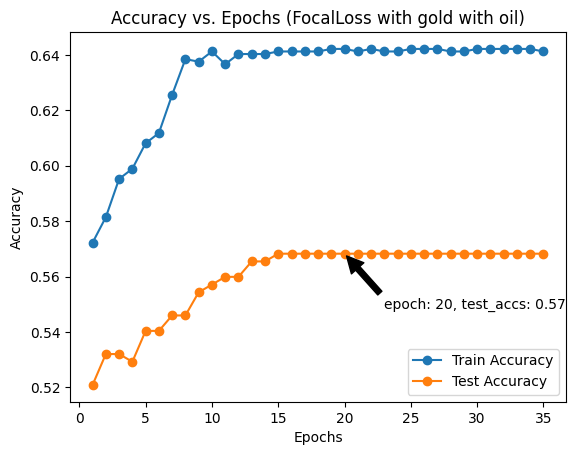

In [27]:
plt.plot(np.arange(1, len(train_accs)+1), train_accs, label='Train Accuracy', marker='o')
# plt.plot(np.arange(0, len(val_accs)), val_accs, label='Validation Accuracy', marker='o')
plt.plot(np.arange(1, len(test_accs)+1), test_accs, label='Test Accuracy', marker='o')

plt.annotate(f'epoch: {early_stopping.best_epoch}, test_accs: {test_accs[early_stopping.best_epoch-1]:.2f}', 
             xy=(early_stopping.best_epoch, test_accs[early_stopping.best_epoch-1]), 
             xytext=(early_stopping.best_epoch + 3, test_accs[early_stopping.best_epoch-1] - 0.02),  # 文本的位置
             arrowprops=dict(facecolor='black', shrink=0.05),  # 箭頭的屬性
             )

plt.legend()
plt.title(f'Accuracy vs. Epochs ({title})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(f'result/{lossFunction}/{title}/acc.png',bbox_inches = 'tight')
plt.show()

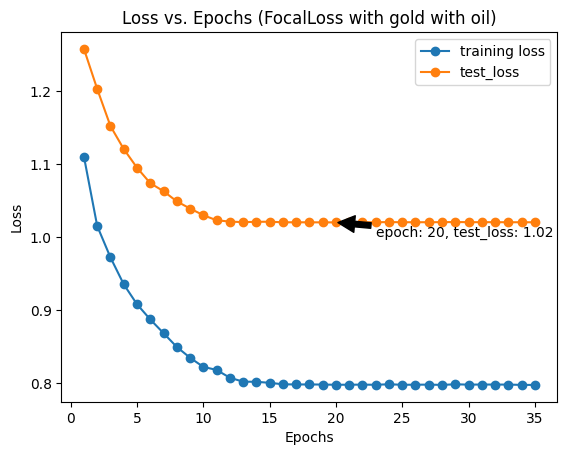

In [28]:
plt.plot(np.arange(1, len(total_train_loss)+1), [tensor.item() for tensor in total_train_loss], label='training loss', marker='o')
plt.plot(np.arange(1, len(total_test_loss)+1), [tensor.item() for tensor in total_test_loss], label='test_loss', marker='o')

plt.legend()
plt.annotate(f'epoch: {early_stopping.best_epoch}, test_loss: {total_test_loss[early_stopping.best_epoch-1]:.2f}', 
             xy=(early_stopping.best_epoch, total_test_loss[early_stopping.best_epoch-1]), 
             xytext=(early_stopping.best_epoch + 3, total_test_loss[early_stopping.best_epoch-1] - 0.02),  # 文本的位置
             arrowprops=dict(facecolor='black', shrink=0.05),  # 箭頭的屬性
             )

plt.title(f'Loss vs. Epochs ({title})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'result/{lossFunction}/{title}/loss.png',bbox_inches = 'tight')
plt.show()

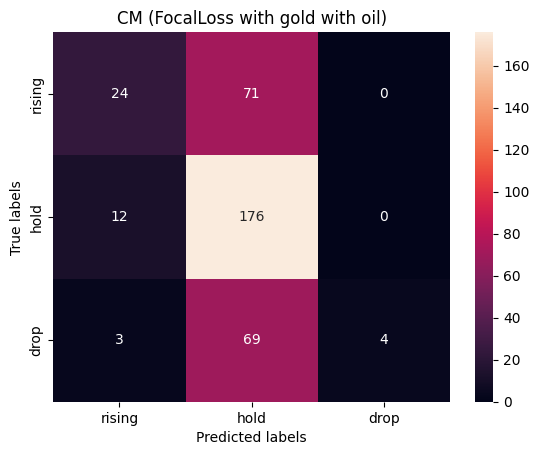

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
labels=['rising','hold','drop']     

fig, ax= plt.subplots()
sns.heatmap(early_stopping.best_test_confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CM (' + title +')')
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
fig.savefig(f'result/{lossFunction}/{title}/cm.png',bbox_inches = 'tight')